### 데이터

In [1]:
from dotenv import load_dotenv

import cv2
import os
import numpy as np
import json
import albumentations as A
from pathlib import Path
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset

c:\Users\ADMIN\Documents\projects\team\Dlthon_01_Motocycle_Night_Ride\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class PathManager:
    """환경 및 모듈 간 규격 클래스"""
    """상황에 맞게 경로와 규격을 수정 후 사용할 것"""
    
    def __init__(self, default_size: int | None = None):
        """dotenv 위치 찾기 + 로드"""
        self.root_path = self._find_root()
        self.dotenv_path = self.root_path / ".env" # 또는 self.dotenv_path = self.root_path / ".env"
        load_dotenv(self.dotenv_path)

        """이미지와 모델 디렉토리 인식"""
        self._images_dir = self.root_path / "data/images"
        self._models_dir = self.root_path / "models"
        self._datas_dir = self.root_path / "data"
        self.default_size = default_size

        self.image_name = None
        self.model_name = None

    def _find_root(self, marker: str=".env") -> Path: # 외부에서 호출할 일 없다.
        """프로젝트 최상단 경로를 찾는 함수"""
        """.env를 마커로 사용"""
        current_cwd = Path().cwd().resolve()
        for parent in current_cwd.parents:
            if (parent / marker).exists():
                return parent

    def get_image_path(self, image_name: str) -> Path:
        """이미지 주소 획득"""
        self.image_name = image_name
        return self._images_dir / image_name
        
    def get_model_path(self, model_name: str) -> Path:
        """모델 주소 획득"""
        self.model_name = model_name
        return self._models_dir / model_name

    def get_data_path(self, data_name: str) -> Path:
        """데이터 주소 획득"""
        self.data_name = data_name
        return self._datas_dir / data_name

def run():
    """앞으로 작업할 모든 작업에서 쓰는 경로 반환 함수"""
    path_manager = PathManager()

    # 기본 경로, 이미지 폴더 경로, 데이터 폴더 경로
    root_path = path_manager.root_path
    images_dir = path_manager._images_dir
    data_dir = path_manager._datas_dir

    # json 경로
    json_path = path_manager.get_data_path("COCO_motorcycle (pixel).json")
    
    # json 로드
    with open (json_path, "r", encoding="utf-8") as f:
        my_json_origin = json.load(f)

    return root_path, images_dir, data_dir, my_json_origin

# root_path: .env 파일의 부모 폴더, images_dir: 이미지 폴더 주소, data_dir: 데이터 폴더 주소, my_json_origin: json파일 객체
root_path, images_dir, data_dir, my_json_origin = run()

In [3]:
# 데이터 검사

all_files = os.listdir(images_dir)
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.webp')

image_files = [
    f for f in all_files 
    if f.lower().endswith(valid_extensions)
    and 'save' not in f.lower() 
    and 'fuse' not in f.lower()
]

json_filenames = {img['file_name'] for img in my_json_origin['images']}
final_image_files = [f for f in image_files if f in json_filenames]

print(f"최종 매칭된 이미지 개수: {len(final_image_files)}장")

최종 매칭된 이미지 개수: 200장


In [23]:
import cv2
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset


# 0번부터 5번까지 6개 클래스를 할당, 배경도 언Undrivable에 포함
CLASS_MAP = {
    'Undrivable': 0,
    'Road': 1,
    'Lane Mark': 2,
    'My bike': 3,
    'Rider': 4,
    'Moveable': 5
}
# 역매핑 (ID -> Name)은 필요할 때 내부에서 생성하거나 별도로 정의
ID_TO_NAME = {v: k for k, v in CLASS_MAP.items()}


class DeepLabDataset(Dataset):
    """데이터셋, 이미지 및 마스크크 리사이즈, 정규화, 텐서화 """

    def __init__(self, image_paths, json_data, class_map):
        self.image_paths = image_paths
        self.json_data = json_data
        self.class_map = class_map
        
        # 520x520 리사이즈 및 텐서 변환
        self.transform = A.Compose([
            # 0. 리사이징 (528, 528)
            A.Resize(1056, 1056, interpolation=cv2.INTER_LINEAR),            
            # # 1. 야간 노이즈 대응 (Gaussian Noise) - "야간 데이터의 특성을 고려했습니다"
            # A.GaussNoise(p=0.2),            
            # # 2. 오토바이의 좌우 주행 가변성 (Horizontal Flip)
            # A.HorizontalFlip(p=0.5),            
            # # 3. 조명 변화 대응 (Random Brightness/Contrast)
            # A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
            # 4. 정규화
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            # 5. 텐서화
            ToTensorV2()
        ])
        
        # 마스크 전용 리사이즈 (정수 값 유지를 위해 별도 처리하거나 Compose 내에서 mask_interpolation 설정)
        # self.mask_resize = A.Resize(528, 528, interpolation=cv2.INTER_NEAREST)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """마스크 제너레이터 함수로 마스크 생성, 이미지와 마스크에 리사이즈 및 정규화 적용"""
        image_path = self.image_paths[idx]
        
        # 1. 원본 이미지 로드 및 bgr2rgb
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 2. 마스크 생성 (기존에 정의한 6개 클래스 로직)
        # 2. 1920x1080 원본 크기로 먼저 생성
        full_mask = self._generate_full_mask(image_path.name, (1080, 1920))

        # 3. 이미지와 마스크 동시 변환 -> Resize(528, 528) 적용
        # 이 한 줄이 이미지와 마스크를 동기화시킵니다.
        transformed = self.transform(image=image, mask=full_mask)
        
        # 결과물에서 각각 꺼내면 이미 동기화된 상태입니다.
        image = transformed['image']
        mask = transformed['mask']
        
        return image, mask.long()

    def _generate_full_mask(self, file_name, shape):
        """JSON의 좌표를 기반으로 1080x1920 마스크 생성"""
        mask = np.zeros(shape, dtype=np.uint8)
        
        # 1. file_name으로 image_id 찾기
        image_info = next((img for img in self.json_data['images'] if img['file_name'] == file_name), None)
        if image_info is None:
            return mask
        
        image_id = image_info['id']
        
        # 2. 해당 image_id를 가진 모든 annotation 가져오기
        annotations = [ann for ann in self.json_data['annotations'] if ann['image_id'] == image_id]
        
        # 3. 카테고리 ID -> 이름 -> 인덱스(0~5) 매핑
        category_id_to_name = {cat['id']: cat['name'] for cat in self.json_data['categories']}
        
        for ann in annotations:
            cat_name = category_id_to_name.get(ann['category_id'])
            label_idx = self.class_map.get(cat_name)
            
            if label_idx is not None:
                for seg in ann['segmentation']:
                    # COCO 포맷의 폴리곤 [x1, y1, x2, y2...]을 numpy 배열로 변환
                    poly = np.array(seg).reshape((-1, 1, 2)).astype(np.int32)
                    # 해당 영역을 label_idx로 채움
                    cv2.fillPoly(mask, [poly], color=label_idx)                    
        return mask



In [24]:
# 데이터 로더

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


def get_loaders(images_dir, json_origin, class_map, batch_size=4):
    """위에서 PathManager 인스턴스 들이 반환한 경로 및 객체들을 인자로 입력"""

    # 해당 디렉토리와 하위 디렉토리의 모든 특정 확장자 파일을 검색 후 리스트 생성
    all_files = list(images_dir.glob("**/*.png"))

    # 2. all_files 중 'fuse'나 'save'가 경로(폴더명 포함)에 들어있는 파일 제외 후 원본 이미지만 담긴 리스트 생성
    images_path_origin = sorted([p for p in all_files if "fuse" not in str(p).lower() and "save" not in str(p).lower()])
    
    # 2. 데이터셋 분할 (160 : 20 : 20)
    train_paths, temp_paths = train_test_split(images_path_origin, train_size=160, test_size=40, random_state=42)
    val_paths, test_paths = train_test_split(temp_paths, train_size=20, test_size=20, random_state=42)

    # 3. 데이터셋 인스턴스 생성
    train_dataset = DeepLabDataset(train_paths, json_origin, class_map)
    val_dataset = DeepLabDataset(val_paths, json_origin, class_map)
    test_dataset = DeepLabDataset(test_paths, json_origin, class_map)

    # 4. 데이터로더 생성 (images, masks 구성), (batch, shuffle 결정)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(len(images_path_origin))

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

# 로더 정의 완료 (train(160), val(20), test(20))
train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_loaders(images_dir, my_json_origin, CLASS_MAP)



200


### 모델

In [6]:
import torch

# 1. CUDA 가속 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 현재 활성화된 연산 장치: {device}")

🚀 현재 활성화된 연산 장치: cuda


In [7]:
import segmentation_models_pytorch as smp

# 가벼운 버전의 아키텍처 제안
model = smp.Unet(                # Unet++ 대신 Unet 사용
    encoder_name="tu-hrnet_w18", # W32 대신 W18 사용
    encoder_weights="imagenet",
    in_channels=3,
    classes=6
).to(device)

print("⚡ 경량화된 HRNet-W18 기반 Unet 로드 완료")

Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.


⚡ 경량화된 HRNet-W18 기반 Unet 로드 완료


In [8]:
import torch.nn.functional as F
import torch.nn as nn


weight_config = {
    'Undrivable': 1.0,
    'Road': 1.0,   
    'Lane Mark': 5.0,  
    'My bike': 1.0,
    'Rider': 1.0,     
    'Moveable': 3.0
}

# 2. CLASS_MAP의 인덱스 순서에 맞춰 텐서로 변환
# sorted(CLASS_MAP, key=CLASS_MAP.get)을 사용하여 인덱스 0부터 5까지 순서를 보장합니다.
weights = torch.tensor(
    [weight_config[name] for name in sorted(CLASS_MAP, key=CLASS_MAP.get)],
    dtype=torch.float32
).to(device)


class DiceCELoss(nn.Module):
    """
    CrossEntropy와 Dice Loss를 결합하여 
    픽셀 분류 정확도와 영역 일치도를 동시에 최적화합니다.
    """
    def __init__(self, weight: torch.Tensor = None, lambda_dice: float = 0.5):
        super(DiceCELoss, self).__init__()
        self.ce = nn.CrossEntropyLoss(weight=weight)
        self.lambda_dice = lambda_dice

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # Standard Cross Entropy
        ce_loss = self.ce(inputs, targets)
        
        # Dice Loss 계산을 위한 전처리
        num_classes = inputs.size(1)
        # targets를 One-hot으로 변환 (B, H, W) -> (B, C, H, W)
        targets_one_hot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()
        # inputs에 Softmax 적용
        inputs_soft = F.softmax(inputs, dim=1)
        
        # Dice Loss 공식: 1 - (2 * intersection + eps) / (sum + eps)
        intersection = (inputs_soft * targets_one_hot).sum(dim=(0, 2, 3))
        union = inputs_soft.sum(dim=(0, 2, 3)) + targets_one_hot.sum(dim=(0, 2, 3))
        
        dice_score = (2. * intersection + 1e-7) / (union + 1e-7)
        dice_loss = 1.0 - dice_score.mean()
        
        # 최종 결합
        return ce_loss + (self.lambda_dice * dice_loss)

# 적용


In [9]:
import torch.nn as nn
import torch.optim as optim


criterion = DiceCELoss(weight=weights)
# criterion = nn.CrossEntropyLoss()

# 0: Undrivable, 1: Road, 2: Lane Mark, 3: My bike, 4: Rider, 5: Moveable
# weights = torch.tensor([1.0, 1.0, 5.0, 1.0, 2.0, 2.0]).to(device)
# criterion = nn.CrossEntropyLoss(weight=weights)
# print("⚖️ 클래스 불균형 해소를 위한 가중치 적용 완료 (Lane Mark x5.0)")

# 4. Optimizer: 수렴 속도가 빠르고 과적합 방지에 유리한 AdamW
# 초기 학습률(lr)은 전이 학습의 안정성을 위해 1e-4로 보수적으로 설정했습니다.
optimizer = optim.AdamW(
    model.parameters(), 
    lr=1e-4, 
    weight_decay=1e-2
)

# 5. Scheduler: 학습이 진행될수록 정교하게 가중치를 튜닝하도록 조절
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80)

In [10]:
from typing import Dict, Any

def get_metrics(
    model: torch.nn.Module, 
    loader: torch.utils.data.DataLoader, 
    device: torch.device, 
    num_classes: int = 6
) -> Dict[str, Any]:
    """
    Confusion Matrix를 활용하여 Segmentation 지표를 효율적으로 계산합니다.
    """
    model.eval()
    conf_matrix = torch.zeros((num_classes, num_classes), device=device)
    
    with torch.inference_mode():  # no_grad보다 최신이며 빠름
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            # Confusion Matrix 업데이트 (이 방식이 훨씬 빠르고 전문적입니다)
            # 2D 연산을 1D로 펼쳐 bincount로 계산하는 테크닉
            conf_matrix += torch.bincount(
                num_classes * masks.view(-1) + preds.view(-1),
                minlength=num_classes**2
            ).reshape(num_classes, num_classes)

    eps = 1e-7
    tp = torch.diag(conf_matrix)
    fp = conf_matrix.sum(dim=0) - tp
    fn = conf_matrix.sum(dim=1) - tp

    iou = tp / (tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    miou = iou.mean().item()

    return {
        'miou': miou,
        'iou': iou.cpu(),
        'precision': precision.cpu(),
        'recall': recall.cpu()
    }

In [11]:
class EarlyStopping:
    def __init__(self, patience=5, path='best_deeplab_night.pth'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_miou, model):
        if self.best_score is None:
            self.best_score = val_miou
            self.save_checkpoint(model)
        elif val_miou < self.best_score:
            self.counter += 1
            print(f"📉 EarlyStopping: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_miou
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)
        print(f"⭐ Best Model Saved! (mIoU: {self.best_score:.4f})")

In [12]:
import wandb

# 1. WandB 초기화
# 아키텍처와 인코더의 조합을 정확히 명시하여 실험의 추적성을 높입니다.
wandb.init(
    project="Dlthon_Motorcycle_Night_Ride",
    name="UnetPlusPlus_HRNetW32_Run_01",  # 실험 회차를 붙여주는 것이 관리하기 편합니다.
    config={
        "learning_rate": 1e-4,
        "epochs": 50,
        "batch_size": 4, 
        "architecture": "UnetPlusPlus",    # 실제 사용 중인 모델로 수정
        "encoder": "HRNet-W32",            # 인코더 명시
        "loss_function": "DiceCELoss",     # 사용 중인 손실 함수 추가 (추천)
        "optimizer": "AdamW"               # 옵티마이저 정보 추가 (추천)
    }
)

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from C:\Users\ADMIN\_netrc.
wandb: Currently logged in as: jongha611 (jongha611-home) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [13]:
import torch
from torch.cuda.amp import autocast, GradScaler
import wandb
from tqdm import tqdm

def train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=80
):
    early_stopping = EarlyStopping(patience=10)
    # 1. GradScaler 초기화 (AMP의 핵심)
    scaler = GradScaler()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for batch_idx, (images, masks) in pbar:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            
            # 2. autocast 적용: FP32와 FP16을 자동으로 혼합하여 연산 속도 향상
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
            
            # 3. Scale을 통한 역전파 및 Step 진행
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # 실시간 로그
            wandb.log({"batch_loss": loss.item()})
            train_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation 파트 (추론 시에도 autocast 권장)
        with autocast():
            metrics = get_metrics(model, val_loader, device) 
        
        val_miou = metrics['miou']
        class_ious = metrics['iou']
        
        log_dict = {
            "train_avg_loss": avg_train_loss,
            "val_miou": val_miou,
            "learning_rate": scheduler.get_last_lr()[0]
        }
        
        for i, iou_val in enumerate(class_ious):
            cls_name = ID_TO_NAME.get(i, f"Class_{i}")
            log_dict[f"IoU/{cls_name}"] = iou_val
            
        wandb.log(log_dict)
        scheduler.step()
        
        print(f"📈 Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | mIoU: {val_miou:.4f}")

        early_stopping(val_miou, model)
        if early_stopping.early_stop:
            print("🛑 Early stopping triggered. Training halted.")
            break
            
    print(f"🏁 Final Best mIoU: {early_stopping.best_score:.4f}")

    print("-" * 30)
    print(f"{'Class Name':<15} | {'IoU':<10}")
    print("-" * 30)
    for i, iou_val in enumerate(class_ious):
        cls_name = ID_TO_NAME[i] if i < len(ID_TO_NAME) else f"Class {i}"
        print(f"{cls_name:<15} | {iou_val:.4f}")
    print("-" * 30)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24720\1009597240.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/80 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24720\1009597240.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/80 [Train]: 100%|██████████| 40/40 [00:24<00:00,  1.67it/s, loss=1.4643]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24720\1009597240.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


📈 Epoch [1/80] | Train Loss: 1.6860 | mIoU: 0.5259
⭐ Best Model Saved! (mIoU: 0.5259)


Epoch 2/80 [Train]: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s, loss=0.9823]


📈 Epoch [2/80] | Train Loss: 1.0753 | mIoU: 0.5968
⭐ Best Model Saved! (mIoU: 0.5968)


Epoch 3/80 [Train]: 100%|██████████| 40/40 [00:23<00:00,  1.72it/s, loss=0.9547]


📈 Epoch [3/80] | Train Loss: 0.8202 | mIoU: 0.6587
⭐ Best Model Saved! (mIoU: 0.6587)


Epoch 4/80 [Train]: 100%|██████████| 40/40 [00:23<00:00,  1.72it/s, loss=0.7446]


📈 Epoch [4/80] | Train Loss: 0.7277 | mIoU: 0.6897
⭐ Best Model Saved! (mIoU: 0.6897)


Epoch 5/80 [Train]: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s, loss=0.5918]


📈 Epoch [5/80] | Train Loss: 0.6000 | mIoU: 0.6809
📉 EarlyStopping: 1 / 10


Epoch 6/80 [Train]: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s, loss=0.4642]


📈 Epoch [6/80] | Train Loss: 0.5398 | mIoU: 0.5955
📉 EarlyStopping: 2 / 10


Epoch 7/80 [Train]: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s, loss=0.4966]


📈 Epoch [7/80] | Train Loss: 0.4919 | mIoU: 0.6789
📉 EarlyStopping: 3 / 10


Epoch 8/80 [Train]: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s, loss=0.5632]


📈 Epoch [8/80] | Train Loss: 0.4685 | mIoU: 0.7172
⭐ Best Model Saved! (mIoU: 0.7172)


Epoch 9/80 [Train]: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s, loss=0.4757]


📈 Epoch [9/80] | Train Loss: 0.4220 | mIoU: 0.7313
⭐ Best Model Saved! (mIoU: 0.7313)


Epoch 10/80 [Train]: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s, loss=0.3960]


📈 Epoch [10/80] | Train Loss: 0.3865 | mIoU: 0.7743
⭐ Best Model Saved! (mIoU: 0.7743)


Epoch 11/80 [Train]: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s, loss=0.4424]


📈 Epoch [11/80] | Train Loss: 0.3584 | mIoU: 0.7581
📉 EarlyStopping: 1 / 10


Epoch 12/80 [Train]: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s, loss=0.2709]


📈 Epoch [12/80] | Train Loss: 0.3714 | mIoU: 0.6583
📉 EarlyStopping: 2 / 10


Epoch 13/80 [Train]: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s, loss=0.2489]


📈 Epoch [13/80] | Train Loss: 0.3381 | mIoU: 0.7357
📉 EarlyStopping: 3 / 10


Epoch 14/80 [Train]: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s, loss=0.2637]


📈 Epoch [14/80] | Train Loss: 0.3008 | mIoU: 0.7960
⭐ Best Model Saved! (mIoU: 0.7960)


Epoch 15/80 [Train]: 100%|██████████| 40/40 [00:22<00:00,  1.76it/s, loss=0.4580]


📈 Epoch [15/80] | Train Loss: 0.2789 | mIoU: 0.7905
📉 EarlyStopping: 1 / 10


Epoch 16/80 [Train]: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s, loss=0.1962]


📈 Epoch [16/80] | Train Loss: 0.2971 | mIoU: 0.7124
📉 EarlyStopping: 2 / 10


Epoch 17/80 [Train]: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s, loss=0.3034]


📈 Epoch [17/80] | Train Loss: 0.2739 | mIoU: 0.7650
📉 EarlyStopping: 3 / 10


Epoch 18/80 [Train]: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s, loss=0.2132]


📈 Epoch [18/80] | Train Loss: 0.2496 | mIoU: 0.7563
📉 EarlyStopping: 4 / 10


Epoch 19/80 [Train]: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s, loss=0.1841]


📈 Epoch [19/80] | Train Loss: 0.2368 | mIoU: 0.7875
📉 EarlyStopping: 5 / 10


Epoch 20/80 [Train]: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s, loss=0.1534]


📈 Epoch [20/80] | Train Loss: 0.2232 | mIoU: 0.8141
⭐ Best Model Saved! (mIoU: 0.8141)


Epoch 21/80 [Train]: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s, loss=0.2093]


📈 Epoch [21/80] | Train Loss: 0.2235 | mIoU: 0.8135
📉 EarlyStopping: 1 / 10


Epoch 22/80 [Train]: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s, loss=0.2752]


📈 Epoch [22/80] | Train Loss: 0.2126 | mIoU: 0.8203
⭐ Best Model Saved! (mIoU: 0.8203)


Epoch 23/80 [Train]: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s, loss=0.1335]


📈 Epoch [23/80] | Train Loss: 0.2057 | mIoU: 0.7953
📉 EarlyStopping: 1 / 10


Epoch 24/80 [Train]: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s, loss=0.1807]


📈 Epoch [24/80] | Train Loss: 0.2252 | mIoU: 0.7850
📉 EarlyStopping: 2 / 10


Epoch 25/80 [Train]: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s, loss=0.1439]


📈 Epoch [25/80] | Train Loss: 0.1873 | mIoU: 0.7661
📉 EarlyStopping: 3 / 10


Epoch 26/80 [Train]: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s, loss=0.1262]


📈 Epoch [26/80] | Train Loss: 0.1584 | mIoU: 0.8084
📉 EarlyStopping: 4 / 10


Epoch 27/80 [Train]: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s, loss=0.2097]


📈 Epoch [27/80] | Train Loss: 0.2190 | mIoU: 0.7950
📉 EarlyStopping: 5 / 10


Epoch 28/80 [Train]: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s, loss=0.1572]


📈 Epoch [28/80] | Train Loss: 0.2136 | mIoU: 0.8065
📉 EarlyStopping: 6 / 10


Epoch 29/80 [Train]: 100%|██████████| 40/40 [00:22<00:00,  1.74it/s, loss=0.1278]


📈 Epoch [29/80] | Train Loss: 0.2034 | mIoU: 0.7726
📉 EarlyStopping: 7 / 10


Epoch 30/80 [Train]: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s, loss=0.2663]


📈 Epoch [30/80] | Train Loss: 0.1991 | mIoU: 0.7949
📉 EarlyStopping: 8 / 10


Epoch 31/80 [Train]: 100%|██████████| 40/40 [00:23<00:00,  1.70it/s, loss=0.1695]


📈 Epoch [31/80] | Train Loss: 0.1989 | mIoU: 0.7921
📉 EarlyStopping: 9 / 10


Epoch 32/80 [Train]: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s, loss=0.1176]


📈 Epoch [32/80] | Train Loss: 0.1753 | mIoU: 0.7823
📉 EarlyStopping: 10 / 10
🛑 Early stopping triggered. Training halted.
🏁 Final Best mIoU: 0.8203
------------------------------
Class Name      | IoU       
------------------------------
Undrivable      | 0.9097
Road            | 0.8263
Lane Mark       | 0.5085
My bike         | 0.8988
Rider           | 0.8598
Moveable        | 0.6906
------------------------------


In [25]:
import torch
from tqdm import tqdm

def evaluate_test_performance(model, test_loader, device, weight_path=None):
    """
    최종 테스트셋을 사용하여 모델의 mIoU 및 클래스별 성능을 평가합니다.
    """
    # 1. 베스트 가중치 로드 (저장된 경로가 있을 경우)
    if weight_path:
        model.load_state_dict(torch.load(weight_path, map_location=device))
        print(f"✅ 가중치 로드 완료: {weight_path}")

    # 2. 모델을 평가 모드로 전환 (Dropout, BatchNormalization 동작 고정)
    model.eval()
    
    # 3. 성능 측정을 위한 추론 루프
    print("🧪 테스트셋 추론 및 mIoU 계산 시작...")
    
    # 기존에 사용하던 get_metrics가 있다면 이를 활용하거나, 
    # 아래와 같이 직접 루프를 돌려 상세 지표를 산출합니다.
    test_metrics = get_metrics(model, test_loader, device)
    
    val_miou = test_metrics['miou']
    class_ious = test_metrics['iou']

    # 4. 결과 리포팅
    print("\n" + "="*40)
    print(f"🏁 [FINAL TEST RESULT] mIoU: {val_miou:.4f}")
    print("="*40)
    
    print(f"{'Class Name':<15} | {'IoU Score':<10}")
    print("-" * 30)
    
    for i, iou_val in enumerate(class_ious):
        # CLASS_MAP 기반으로 이름 매핑
        cls_name = ID_TO_NAME.get(i, f"Class {i}")
        print(f"{cls_name:<15} | {iou_val:.4f}")
    
    print("-" * 30)
    return test_metrics

# 실행 예시
# weight_path = "best_model.pth" (학습 시 EarlyStopping으로 저장된 파일)
results = evaluate_test_performance(model, test_loader, device, weight_path="best_deeplab_night.pth")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24720\1244371823.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path, map_location=

✅ 가중치 로드 완료: best_deeplab_night.pth
🧪 테스트셋 추론 및 mIoU 계산 시작...

🏁 [FINAL TEST RESULT] mIoU: 0.8348
Class Name      | IoU Score 
------------------------------
Undrivable      | 0.9355
Road            | 0.8711
Lane Mark       | 0.5079
My bike         | 0.9632
Rider           | 0.9487
Moveable        | 0.7822
------------------------------


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24720\214829592.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_deeplab_night.pth"))


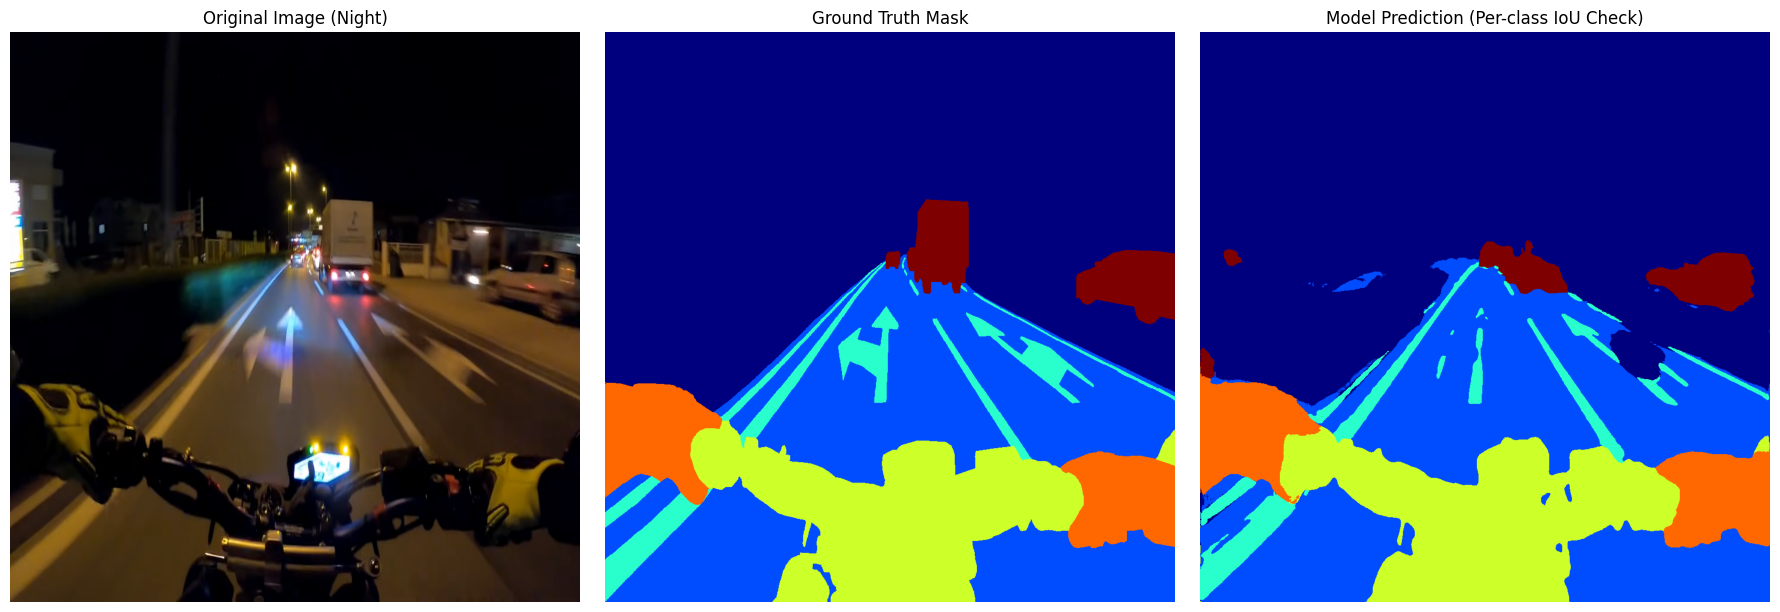

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction(model, dataset, device, sample_idx=0):
    model.load_state_dict(torch.load("best_deeplab_night.pth"))
    model.eval()
    
    # 1. 데이터 가져오기
    image_tensor, mask_target = dataset[sample_idx]
    
    # 2. 모델 추론
    with torch.no_grad():
        input_tensor = image_tensor.unsqueeze(0).to(device)
        output = model(input_tensor)
        mask_pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    
    # 3. 시각화를 위한 역정규화
    img_show = image_tensor.permute(1, 2, 0).numpy()
    img_show = img_show * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_show = np.clip(img_show, 0, 1)
    
    # 4. 시각화 (원본 | 정답 | 예측)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(img_show)
    axes[0].set_title("Original Image (Night)")
    axes[0].axis('off')
    
    # 정답 마스크 (Lane Mark는 특정 색으로 강조됨)
    axes[1].imshow(mask_target, cmap='jet', vmin=0, vmax=5)
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')
    
    # 모델 예측 마스크
    axes[2].imshow(mask_pred, cmap='jet', vmin=0, vmax=5)
    axes[2].set_title(f"Model Prediction (Per-class IoU Check)")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# 실행: 검증 데이터셋 중 하나를 골라 확인
visualize_prediction(model, test_dataset, device, sample_idx=18)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_24720\1944655719.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_deeplab_night.pth"))


🧪 P-R 분석을 위한 추론 시작 (이 작업은 다소 시간이 소요될 수 있습니다)...


c:\Users\ADMIN\Documents\projects\team\Dlthon_01_Motocycle_Night_Ride\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ADMIN\Documents\projects\team\Dlthon_01_Motocycle_Night_Ride\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ADMIN\Documents\projects\team\Dlthon_01_Motocycle_Night_Ride\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ADMIN\Documents\projects\team\Dlthon_01_Motocycle_Night_Ride\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(byt

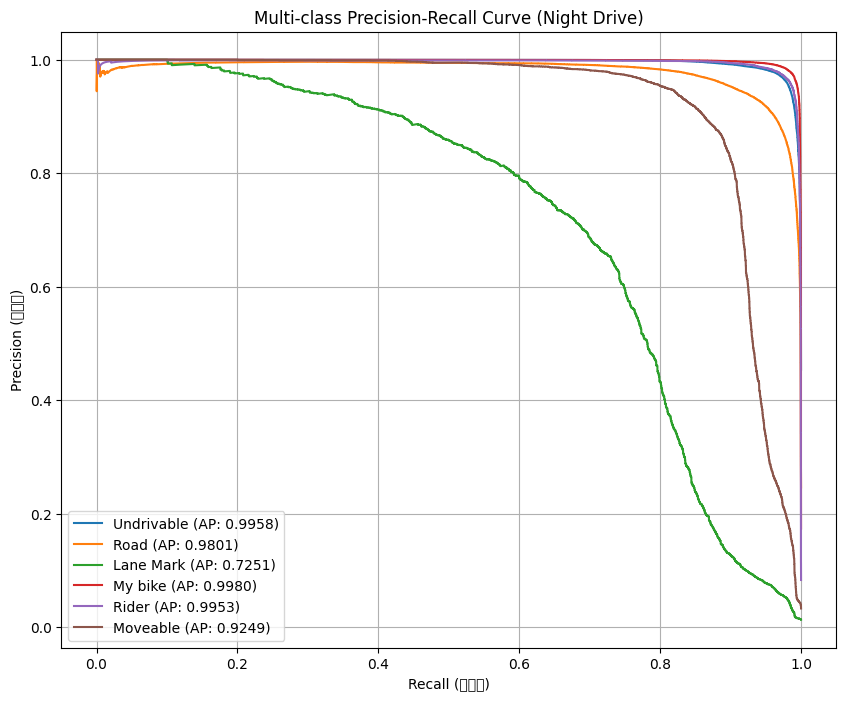

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curves(model, loader, device, num_classes=6, class_names=None):
    model.load_state_dict(torch.load("best_deeplab_night.pth"))
    model.eval()
    
    # 각 클래스별로 실제 값과 예측 확률을 저장할 리스트
    all_targets = [[] for _ in range(num_classes)]
    all_probs = [[] for _ in range(num_classes)]
    
    print("🧪 P-R 분석을 위한 추론 시작 (이 작업은 다소 시간이 소요될 수 있습니다)...")
    
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            # Softmax를 통과시켜 확률값(0~1)으로 변환
            probs = torch.softmax(outputs, dim=1)
            
            for cls in range(num_classes):
                # 해당 클래스에 대한 정답(1)과 오답(0) 바이너리 마스크
                target_cls = (masks == cls).float().cpu().numpy().flatten()
                prob_cls = probs[:, cls, :, :].cpu().numpy().flatten()
                
                # 메모리 효율을 위해 샘플링 (모든 픽셀을 다 넣으면 RAM 부족 위험)
                # 1/100 정도만 샘플링해도 경향성 파악에는 충분합니다.
                indices = np.random.choice(len(target_cls), len(target_cls)//100, replace=False)
                all_targets[cls].extend(target_cls[indices])
                all_probs[cls].extend(prob_cls[indices])

    # 그래프 그리기
    plt.figure(figsize=(10, 8))
    for cls in range(num_classes):
        precision, recall, _ = precision_recall_curve(all_targets[cls], all_probs[cls])
        ap = average_precision_score(all_targets[cls], all_probs[cls])
        
        name = class_names[cls] if class_names else f"Class {cls}"
        plt.plot(recall, precision, label=f'{name} (AP: {ap:.4f})')

    plt.xlabel('Recall (재현율)')
    plt.ylabel('Precision (정밀도)')
    plt.title('Multi-class Precision-Recall Curve (Night Drive)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# 실행 예시
CLASS_NAMES = ["Undrivable", "Road", "Lane Mark", "My bike", "Rider", "Moveable"]
plot_pr_curves(model, test_loader, device, num_classes=6, class_names=CLASS_NAMES)

In [28]:
import torch
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def get_gradcam_visual(model, input_tensor, original_image, class_idx=1):
    """
    DeepLabV3+ ResNet50 모델에 대한 Grad-CAM 시각화.
    class_idx: 1(Lane Mark), 2(Moveable) 등 분석하고 싶은 클래스
    """
    model.eval()
    
    # 1. 타겟 레이어 설정 (ResNet50의 Layer 4 마지막 블록)
    # 모델 정의 방식에 따라 'model.encoder.layer4' 등으로 수정이 필요할 수 있습니다.
    target_layers = [model.backbone.layer4[-1]]
    
    # 2. 세그멘테이션용 타겟 설정 (특정 클래스의 픽셀들을 타겟으로 함)
    # 해당 클래스가 예측된 영역 전체에 대한 그라디언트를 계산합니다.
    targets = [SemanticSegmentationTarget(class_idx, None)]
    
    # 3. Grad-CAM 실행
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
        
    # 4. 시각화 합성
    # original_image는 [0, 1] 사이의 float32 numpy 배열이어야 함 (H, W, 3)
    cam_image = show_cam_on_image(original_image, grayscale_cam, use_rgb=True)
    
    return cam_image

Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.
C:\Users\ADMIN\A

✅ HRNet-W18 가중치 로드 성공


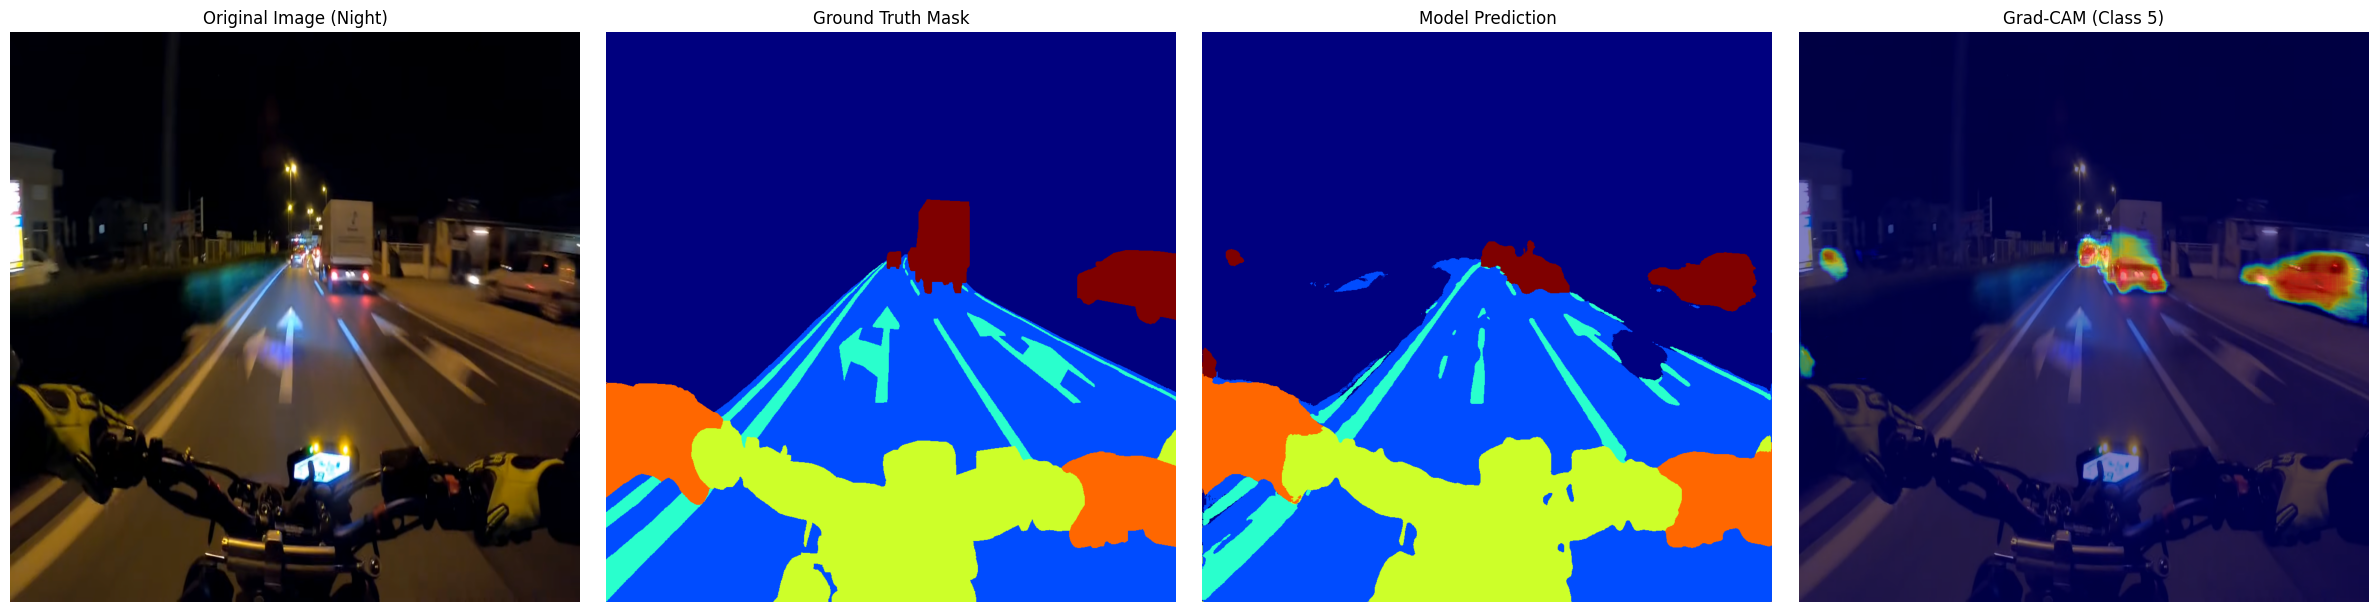

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1. HRNet 리스트 출력을 텐서로 변환하는 전처리 함수
def hrnet_reshape_transform(tensor):
    """
    HRNet은 [High-Res, Mid-Res, Low-Res] 리스트를 반환하므로, 
    가장 해상도가 높은 첫 번째 브랜치를 선택하여 시각화합니다.
    """
    return tensor

# 2. Grad-CAM 시각화 함수 정의
def visualize_prediction_with_cam(model, dataset, device, sample_idx=0, class_idx=1):
    model.eval()
    
    # 데이터 가져오기 및 텐서 변환
    image_tensor, mask_target = dataset[sample_idx]
    input_tensor = image_tensor.unsqueeze(0).to(device)
    
    # 모델 추론
    with torch.no_grad():
        output = model(input_tensor)
        mask_pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # 해당 클래스에 대한 바이너리 마스크 생성
    mask_float = np.float32(mask_pred == class_idx)
    if np.sum(mask_float) == 0:
        mask_float = np.ones_like(mask_pred, dtype=np.float32)

    # [핵심] HRNet-W18 타겟 레이어 및 변환 함수 설정
    # timm 인코더 내부의 stage4 마지막 블록을 타겟팅합니다.
    target_layers = [model.decoder.blocks[-1]]
    targets = [SemanticSegmentationTarget(class_idx, mask_float)]
    
    # Grad-CAM 실행 (reshape_transform 주입)
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
    
    # 역정규화 (ImageNet 기준)
    img_show = image_tensor.permute(1, 2, 0).numpy()
    img_show = img_show * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_show = np.clip(img_show, 0, 1)
    
    # 원본 이미지와 히트맵 합성
    cam_image = show_cam_on_image(img_show, grayscale_cam, use_rgb=True)

    # 결과 시각화
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    axes[0].imshow(img_show); axes[0].set_title("Original Image (Night)")
    axes[1].imshow(mask_target, cmap='jet', vmin=0, vmax=5); axes[1].set_title("Ground Truth Mask")
    axes[2].imshow(mask_pred, cmap='jet', vmin=0, vmax=5); axes[2].set_title("Model Prediction")
    axes[3].imshow(cam_image); axes[3].set_title(f"Grad-CAM (Class {class_idx})")
    
    for ax in axes: ax.axis('off')
    plt.tight_layout()
    plt.show()

# --- 메인 실행부 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WEIGHT_PATH = "best_deeplab_night.pth" 

# 모델 아키텍처 재선언
model = smp.Unet(
    encoder_name="tu-hrnet_w18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=6
).to(device)

# 가중치 로드
try:
    model.load_state_dict(torch.load(WEIGHT_PATH, map_location=device))
    print(f"✅ HRNet-W18 가중치 로드 성공")
except Exception as e:
    print(f"⚠️ 가중치 로드 중 주의사항: {e}")
    print("로드 실패 시 모델 구조와 가중치 파일의 클래스 개수가 일치하는지 확인하세요.")

# 시각화 호출 (sample_idx=18, class_idx=2)
visualize_prediction_with_cam(model, test_dataset, device, sample_idx=18, class_idx=5)

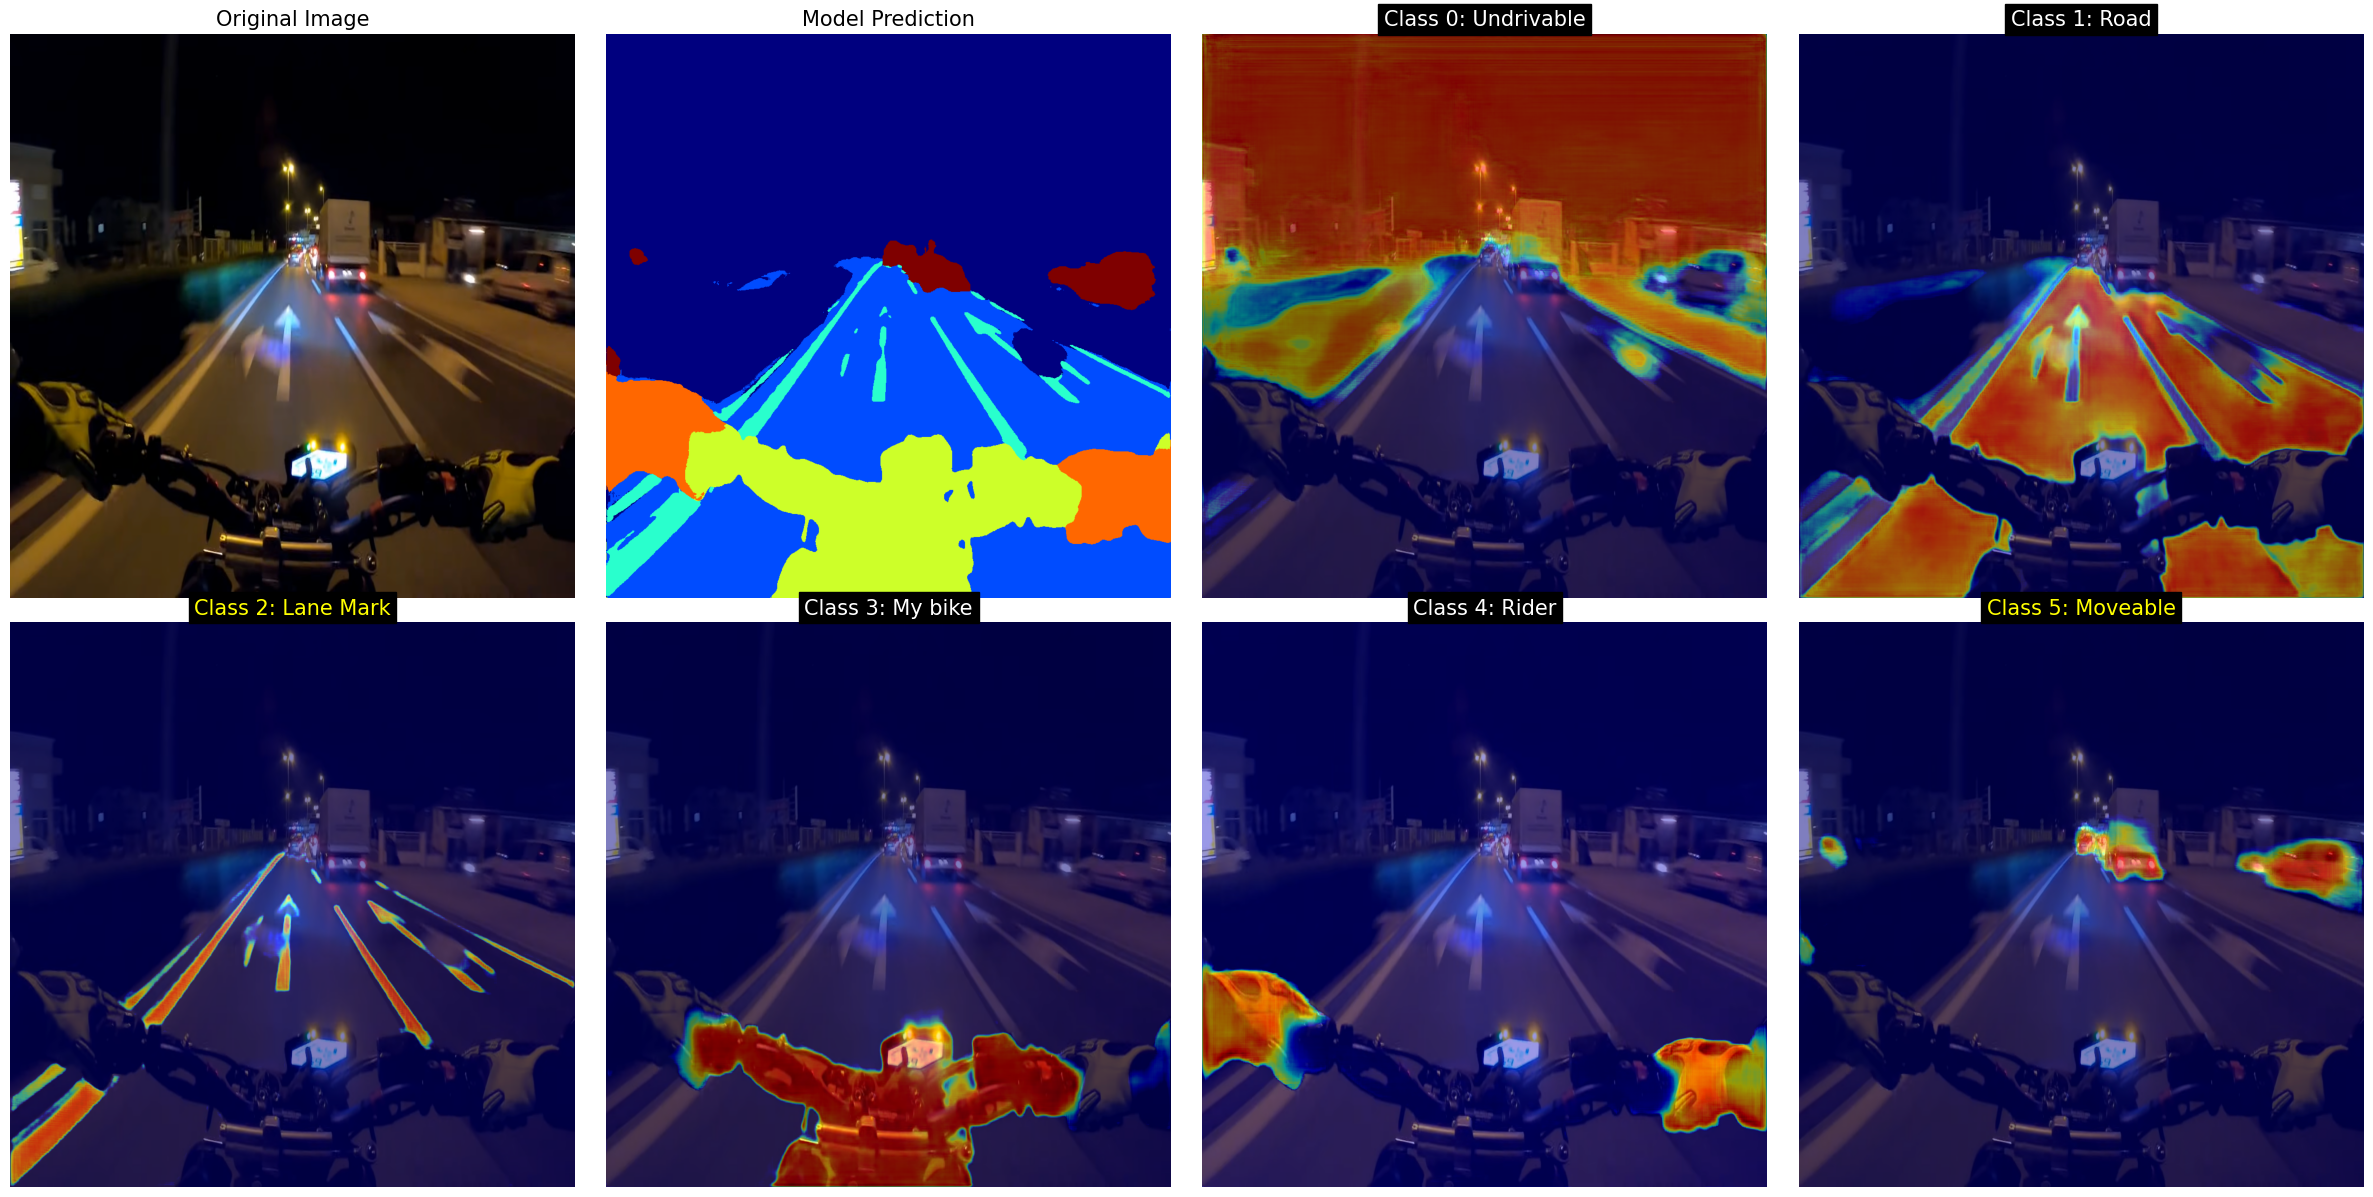

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_all_classes_gradcam(model, dataset, device, sample_idx=0):
    model.eval()
    
    # 1. 데이터 준비
    image_tensor, mask_target = dataset[sample_idx]
    input_tensor = image_tensor.unsqueeze(0).to(device)
    
    # 클래스 이름 정의 (종하 님의 설정 기준)
    class_names = ['Undrivable', 'Road', 'Lane Mark', 'My bike', 'Rider', 'Moveable']
    
    # 2. 타겟 레이어 설정 (최종 결정이 내려지는 Decoder의 마지막 블록)
    # 인코더보다 객체 중심적인(Object-centric) 활성화 맵을 보여줍니다.
    target_layers = [model.decoder.blocks[-1]]
    
    # 3. 모델 추론 (예측 결과 확인용)
    with torch.no_grad():
        output = model(input_tensor)
        mask_pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # 4. 이미지 역정규화
    img_show = image_tensor.permute(1, 2, 0).numpy()
    img_show = img_show * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_show = np.clip(img_show, 0, 1)

    # 5. 시각화 레이아웃 설정 (2x4 Grid)
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    axes = axes.flatten()

    # 첫 번째 칸: 원본 이미지 및 예측 결과
    axes[0].imshow(img_show)
    axes[0].set_title("Original Image", fontsize=15)
    
    axes[1].imshow(mask_pred, cmap='jet', vmin=0, vmax=5)
    axes[1].set_title("Model Prediction", fontsize=15)

    # 6. 각 클래스별 Grad-CAM 생성 및 플로팅
    with GradCAM(model=model, target_layers=target_layers) as cam:
        for i in range(6):
            # 해당 클래스의 예측 영역을 기반으로 타겟 생성
            mask_float = np.float32(mask_pred == i)
            if np.sum(mask_float) == 0:  # 예측이 없는 클래스는 전체 영역을 대상으로 Fallback
                mask_float = np.ones_like(mask_pred, dtype=np.float32)
            
            targets = [SemanticSegmentationTarget(i, mask_float)]
            
            # Grad-CAM 연산
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
            cam_image = show_cam_on_image(img_show, grayscale_cam, use_rgb=True)
            
            # 그래프에 추가 (인덱스 2번부터 클래스 0~5 출력)
            axes[i+2].imshow(cam_image)
            axes[i+2].set_title(f"Class {i}: {class_names[i]}", fontsize=15, 
                                color='yellow' if i in [2, 5] else 'white', # 중요 클래스 강조
                                backgroundcolor='black')

    for ax in axes: ax.axis('off')
    plt.tight_layout()
    plt.show()

# 실행
visualize_all_classes_gradcam(model, test_dataset, device, sample_idx=18)

--- [Index 18] Actual Mask Values Found: [0 1 2 3 4 5] ---


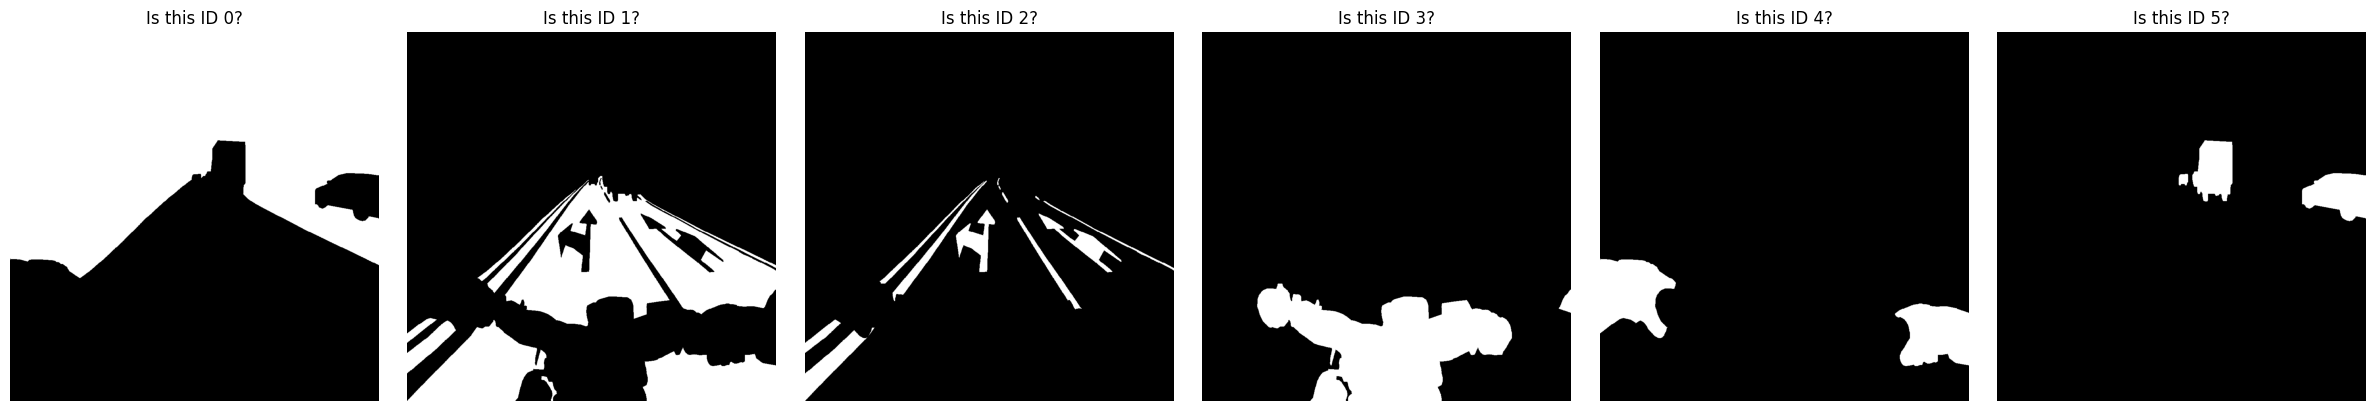

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def verify_class_mapping(dataset, sample_idx=0):
    """
    데이터셋의 실제 마스크 값과 CLASS_MAP의 일치 여부를 검증함.
    """
    image, mask = dataset[sample_idx]
    
    # 텐서라면 numpy로 변환
    if hasattr(mask, 'numpy'):
        mask = mask.numpy()
        
    unique_ids = np.unique(mask)
    print(f"--- [Index {sample_idx}] Actual Mask Values Found: {unique_ids} ---")

    # 각 인덱스별로 시각화하여 정체 파악
    fig, axes = plt.subplots(1, len(unique_ids), figsize=(4 * len(unique_ids), 4))
    if len(unique_ids) == 1:
        axes = [axes]

    for i, class_id in enumerate(unique_ids):
        # 특정 ID에 해당하는 픽셀만 추출 (Binary Mask)
        class_mask = (mask == class_id)
        axes[i].imshow(class_mask, cmap='gray')
        axes[i].set_title(f"Is this ID {class_id}?")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 사용 예시: 18번 샘플의 실제 마스크 구조 확인
verify_class_mapping(test_dataset, sample_idx=18)